# Math 46 Project - Spreading Rumor

### Basic Model

In the most basic model, we implement an equivalent of SI model in homogeneous network. We assume there are (S) spreaders and (I)ignorants.

Definitions : 
- $T$ : Total Population 
- $s$ : proportion of the population that has already heard the rumor
- $p$ : probability that a spreader spreads information to an ignorant
- $\langle k \rangle$ : average degree of the network

Given such parameters we can set up a differential equation as follows : 
$$\frac{ds}{dt} = p\langle k\rangle s(1-s)$$
Note that since we do not have any recovery, we will always reach a steady state of everyone hearing the rumor in finite time as long as $p$ is non-negative 

We solve the equation : 

$$
\begin{align}
\frac{1}{s(1-s)}ds&=p\langle k\rangle dt\\
\left( \frac{1}{s} + \frac{1}{1-s} \right) ds&=p\langle k\rangle dt\\
\ln \frac{s}{1-s} &= c \exp (p\langle k\rangle t)\\
s &= \frac{c \exp (p\langle k\rangle t)}{1+c \exp (p\langle k\rangle t)}\\
\text{we have initial condition } s(0) &= \frac{n_0}{T}\\
c & = \frac{n_0}{T-n_0}
\end{align}
$$

In [2]:
# Define the function that will spread the information in G
# for given spread probability p for t number of iterations
def spreadInfo(G, spreaders, p, t):
    n = G.number_of_nodes()
    NumSpreaders = [len(spreaders)/n]
    iter = 0
    for i in range(0,t):
        iter = iter + 1
        newspreaders = spreaders.copy()
        for person in spreaders :
            neighbors = G.neighbors(person)
            for neighbor in neighbors:
                if (random.random() < p) and (neighbor not in newspreaders) : 
                    newspreaders.add(neighbor)
                    G.node[neighbor]['color'] = 'b'
                    G.node[neighbor]['spreader'] = 1
        spreaders = newspreaders.copy()
        NumSpreaders.append(len(spreaders)/n)
        #if len(spreaders) == n:
         #   break
    return(G, spreaders, NumSpreaders, iter)

# Returns theoretical model
def get_simple_model(T, init, p, k):
    model = []
    C = init/(T-init)
    for i in range(0,t+1):
        num = C*math.exp(p*k*i)
        model.append(num/(1+num))
    return (model)
        

# Creates a configuration Model
def create_configuration_model(deg, init):
    cm=nx.configuration_model(deg) 
    for node in cm.nodes():
        cm.node[node]['color'] = 'w'
        
    cm_spreaders = set()
    initspreader = random.sample(range(len(deg)), init)
    for i in initspreader:
            cm.node[i]['color'] = 'b'
            cm_spreaders.add(i)
            
    return [cm, cm_spreaders]

# Creates Erdos Renyi Model
def create_er_model(T, k, init):
    p_edge = k / T
    er=nx.erdos_renyi_graph(T,p_edge) #er.nodes(data=True)
    for node in er.nodes():
        er.node[node]['color'] = 'w'
        
    er_spreaders = set()
    initspreader = random.sample(range(T),init)
    for i in initspreader:
            er.node[i]['color'] = 'b'
            er_spreaders.add(i)
    
    return [er, er_spreaders]

# Creates Watts Strogatz Model
def create_ws_model(T, k , p_rewire, init):
    ws=nx.watts_strogatz_graph(T,k,p_rewire) 
    for node in ws.nodes():
        ws.node[node]['color'] = 'w'
        
    ws_spreaders = set()
    initspreader = random.sample(range(T),init)
    for i in initspreader:
            ws.node[i]['color'] = 'b'
            ws_spreaders.add(i)
    
    return [ws, ws_spreaders]

#### Tests on various Models

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import time
import math
random.seed(0)


# Simulates Simple Configuration Model
def simulate_simple_configuration(T, k, deg, p, t, init, iterNum):
    
    avgNumSpreaders = np.array([0 for i in range(t+1)])
    
    for i in range(iterNum):
        random.shuffle(deg)
        [cm, cm_spreaders] = create_configuration_model(deg, init)
        
        if(i == 0):
            plt.figure(figsize=(20,5))
            plt.subplot(131)
            plt.title('Initial Network')
            nx.draw(cm,nx.circular_layout(cm),with_labels=False,node_color=[cm.node[node]['color'] for node in cm])
        
        cm, cm_spreaders, cm_NumSpreaders, cm_tStop = spreadInfo(cm, cm_spreaders, p, t)
        if(i == 0):
            plt.subplot(132)
            plt.title('Network after '+ str(t)  + ' iterations')
            nx.draw(cm,nx.circular_layout(cm),with_labels=False,node_color=[cm.node[node]['color'] for node in cm])
            plt.subplot(133)
            plt.title('Degree distribution')
            plt.hist(list(cm.degree().values()))
        avgNumSpreaders = avgNumSpreaders + np.array(cm_NumSpreaders)
    
    avgNumSpreaders = avgNumSpreaders / iterNum
    
    # Compute theoretical Model
    cm_model =  get_simple_model(T, init, p, k)
    
    plt.figure(figsize=(20,10))
    ax = plt.subplot(111)
    s, = plt.plot(avgNumSpreaders, 'b--',linewidth=4)
    s_model, = plt.plot(cm_model, 'k', linewidth =4)
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
    ax.legend([s, s_model], ['s', 's_model'],
              loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=2, fontsize = 25)
    
    text = ' T = %d, k = %d, p = %.3f,\n t = %d,init = %d, iterNum = %d' %(T, k, p, t, init, iterNum) 
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.5, .98, text,fontsize=14, verticalalignment='top', bbox=props)
    plt.title('Simple Model (configuration model)',fontsize = 20)

    plt.xlim(0,t)
    plt.ylim(0,1)
            

In [4]:
# Simulates Simple Erdos-Renyi Model
def simulate_simple_er(T, k, p, t, init, iterNum):
    
    avgNumSpreaders = np.array([0 for i in range(t+1)])
    avgDegrees = np.array([0 for i in range(T)])
    
    for i in range(iterNum):
        [er, er_spreaders] = create_er_model(T, k, init)
        
        if(i == 0):
            plt.figure(figsize=(20,5))
            plt.subplot(131)
            plt.title('Initial Network')
            nx.draw(er,nx.circular_layout(er),with_labels=False,node_color=[er.node[node]['color'] for node in er])
        
        er, er_spreaders, er_NumSpreaders, er_tStop = spreadInfo(er, er_spreaders, p, t)
        if(i == 0):
            plt.subplot(132)
            plt.title('Network after '+ str(t)  + ' iterations')
            nx.draw(er,nx.circular_layout(er),with_labels=False,node_color=[er.node[node]['color'] for node in er])

        avgNumSpreaders = avgNumSpreaders + np.array(er_NumSpreaders)
        avgDegrees = avgDegrees + np.array(list(er.degree().values()))
    
    avgNumSpreaders = avgNumSpreaders / iterNum
    avgDegrees = avgDegrees / iterNum
    
    plt.subplot(133)
    plt.title('Degree distribution (Average)')
    plt.hist(avgDegrees)
    
    # Compute theoretical Model
    er_model =  get_simple_model(T, init, p, k)
    
    plt.figure(figsize=(20,10))
    ax = plt.subplot(111)
    s, = plt.plot(avgNumSpreaders, 'b--',linewidth=4)
    s_model, = plt.plot(er_model, 'k', linewidth =4)
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
    ax.legend([s, s_model], ['s', 's_model'],
              loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=2, fontsize = 25)
    
    text = ' T = %d, k = %d, p = %.3f,\n t = %d,init = %d, iterNum = %d' %(T, k, p, t, init, iterNum) 
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.5, .98, text,fontsize=14, verticalalignment='top', bbox=props)
    plt.title('Simple Model (Erdos-Renyi model)',fontsize = 20)

    plt.xlim(0,t)
    plt.ylim(0,1)

In [5]:
# Simulates Simple Watts Strogatz Model
def simulate_simple_ws(T, k, p, p_rewire, t, init, iterNum):
    
    avgNumSpreaders = np.array([0 for i in range(t+1)])
    avgDegrees = np.array([0 for i in range(T)])
    
    for i in range(iterNum):
        [ws, ws_spreaders] = create_ws_model(T, k , p_rewire, init)
        
        if(i == 0):
            plt.figure(figsize=(20,5))
            plt.subplot(131)
            plt.title('Initial Network')
            nx.draw(ws,nx.circular_layout(ws),with_labels=False,node_color=[ws.node[node]['color'] for node in ws])
        
        ws, ws_spreaders, ws_NumSpreaders, ws_tStop = spreadInfo(ws, ws_spreaders, p, t)
        if(i == 0):
            plt.subplot(132)
            plt.title('Network after '+ str(t)  + ' iterations')
            nx.draw(ws,nx.circular_layout(ws),with_labels=False,node_color=[ws.node[node]['color'] for node in ws])

        avgNumSpreaders = avgNumSpreaders + np.array(ws_NumSpreaders)
        avgDegrees = avgDegrees + np.array(list(ws.degree().values()))
    
    avgNumSpreaders = avgNumSpreaders / iterNum
    avgDegrees = avgDegrees / iterNum
    
    plt.subplot(133)
    plt.title('Degree distribution (Average)')
    plt.hist(avgDegrees)
    
    # Compute theoretical Model
    ws_model =  get_simple_model(T, init, p, k)
    
    plt.figure(figsize=(20,10))
    ax = plt.subplot(111)
    s, = plt.plot(avgNumSpreaders, 'b--',linewidth=4)
    s_model, = plt.plot(ws_model, 'k', linewidth =4)
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
    ax.legend([s, s_model], ['s', 's_model'],
              loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=2, fontsize = 25)
    
    text = ' T = %d, k = %d, p = %.3f, p_rewire = %.3f, \n t = %d,init = %d, iterNum = %d' %(T, k, p, p_rewire, t, init, iterNum) 
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.5, .98, text,fontsize=14, verticalalignment='top', bbox=props)
    plt.title('Simple Model (Watts-Strogatz model)',fontsize = 20)

    plt.xlim(0,t)
    plt.ylim(0,1)

#### Configuration Model (equal degree)

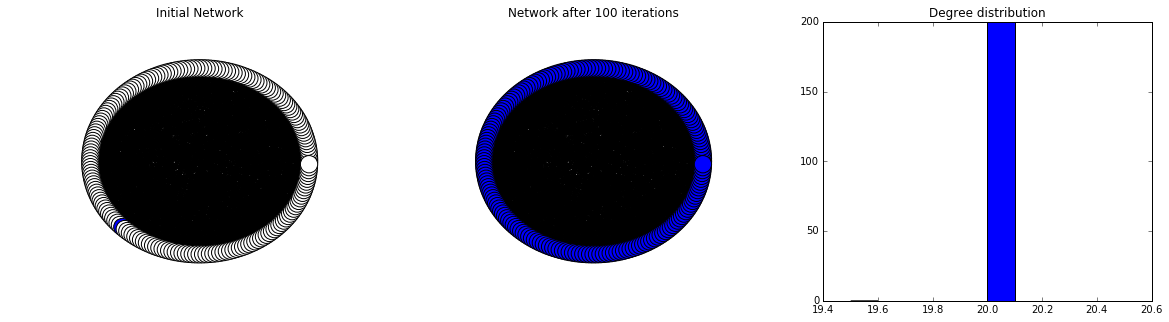

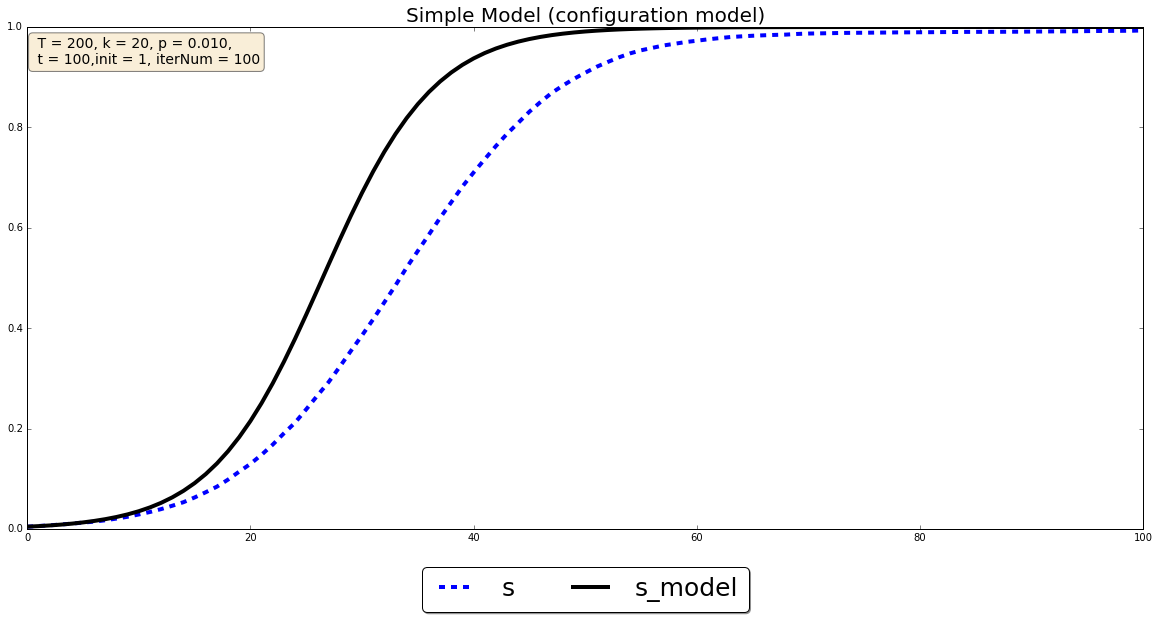

In [10]:
random.seed(0)

T = 200
k = 20
deg = [k for i in range(0,T)]
p = 0.01
init = 1
t = 100
iterNum = 100

simulate_simple_configuration(T, k, deg, p, t, init, iterNum)

#### Erdos Renyi

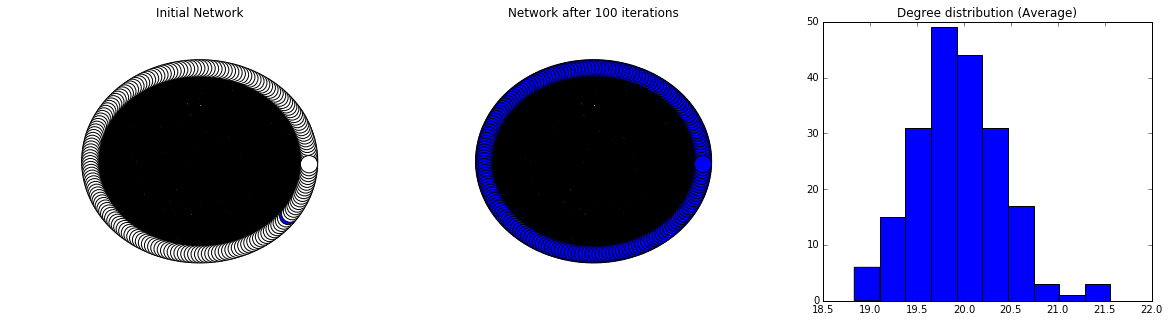

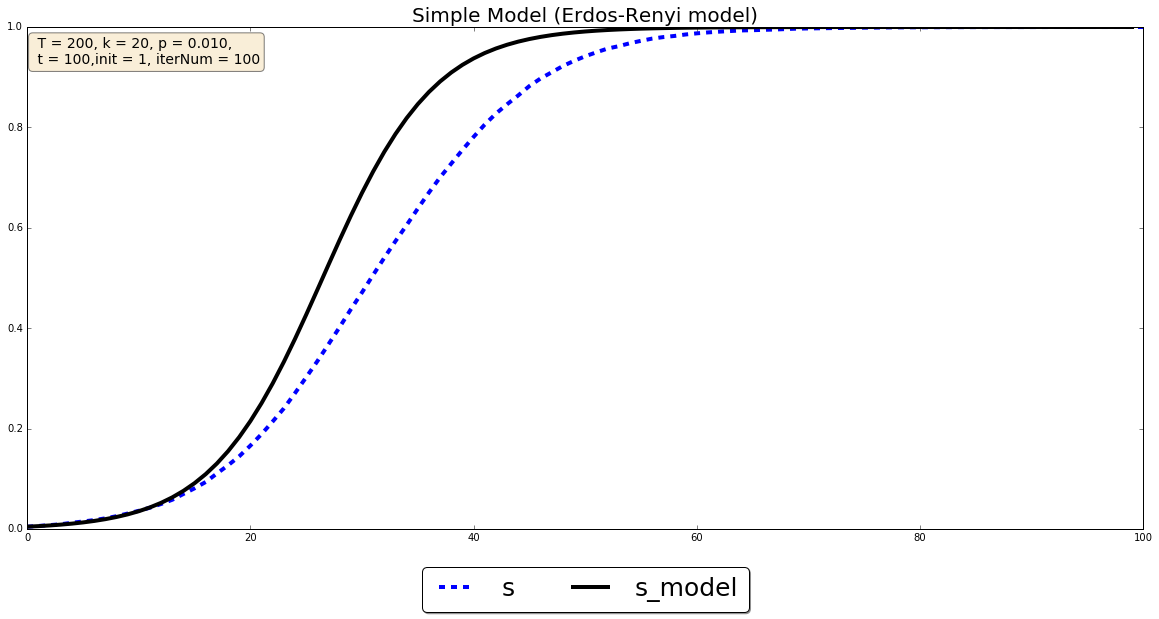

In [11]:
random.seed(0)

T = 200
k = 20
p_edge = k / T
p = 0.01
t = 100
init = 1
iterNum = 100

simulate_simple_er(T, k, p, t, init, iterNum)

#### Watts-Strogatz Model

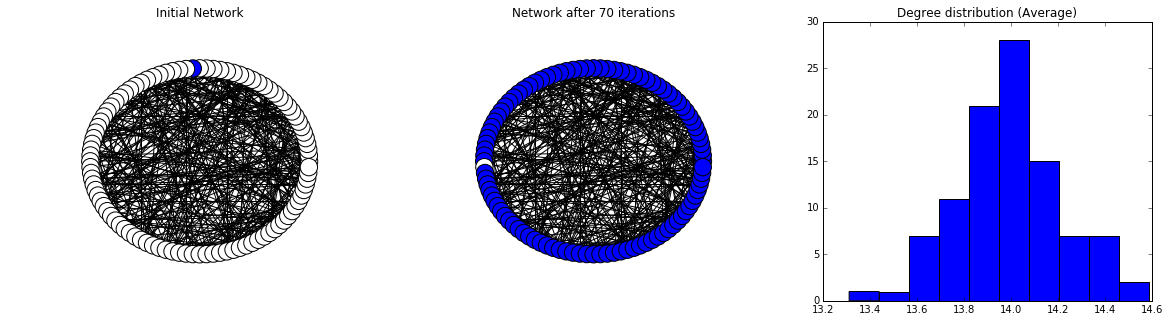

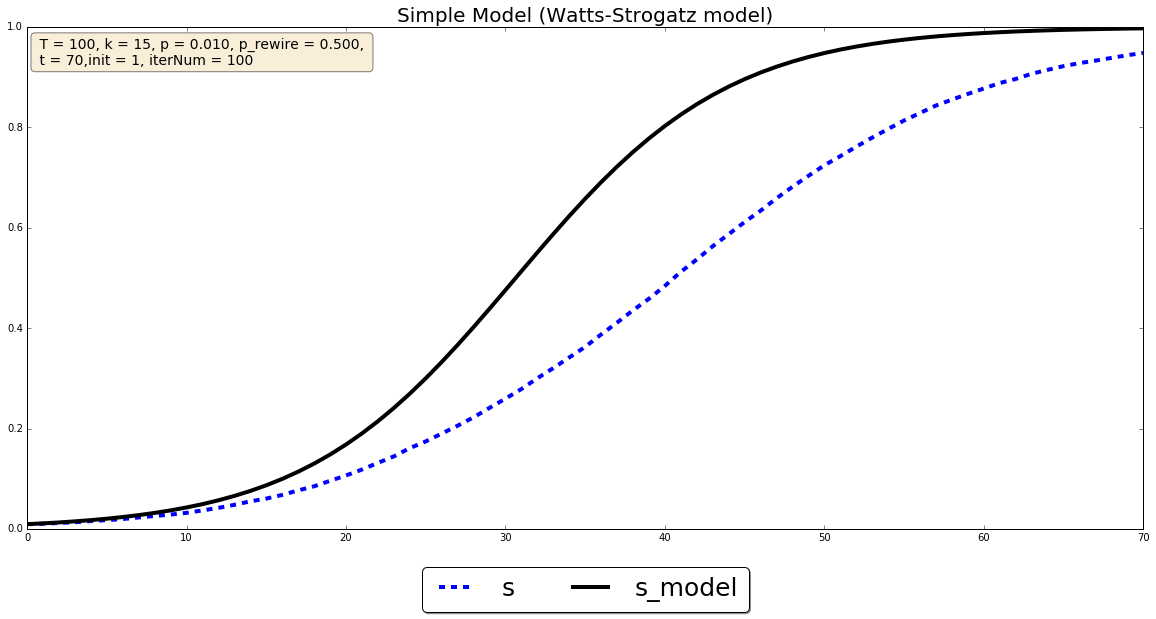

In [62]:
random.seed(0)

# Set Parameters
T = 100
k = 15
p_rewire = 0.5
p = 0.01
t = 70
init = 1
iterNum = 100


simulate_simple_ws(T, k, p, p_rewire, t, init, iterNum)

### Two Population Model

Next, we define a two population model. In this model, there are two types of people with two different probabilities of information spreading. It may be thought of measure of *talkativity*. We have parameters as follows : 

- $T,T_1,T_2$ : Total population, population group 1 and 2
- $s_1,s_2$ : proportion of the total population in each group that has already heard the rumor
- $w_1,w_2$ : proportion of the total population that belongs to each group. That is, $T_1 = w_1 T$ and $T_2 = w_2 T$
- $p_1,p_2$ : probability that a spreader spreads information to an ignorant in group 1 and 2, respectively
- $\langle k \rangle$ : average degree of the network

We follow similar derivations as before, except that now we have more complicated interation, as an ignorant may hear information from spreaders from either group. Note that in the case when $p_i=0$, we are basically introducing a SIR model with S(stiflers) population who does not spread any information.

We have the following differential equations : 

$$\begin{align}
\frac{ds_1}{dt} &= p_1w_1 \langle k \rangle s_1 (w_1-s_1) + p_2 w_1 \langle k \rangle s_2 (w_1-s_1)\\
\frac{ds_2}{dt} &= p_1w_2 \langle k \rangle s_1 (w_2-s_2) + p_2 w_2 \langle k \rangle s_2 (w_2-s_2)
\end{align}$$


In [12]:
# Define the function that will spread the information in G
# for given spread probability p1, p2 for t number of iterations
def spreadInfo_TwoPopulation(G, T1set, T2set, spreaders1, spreaders2, p1, p2, t):
    n = G.number_of_nodes()
    NumSpreaders1 = [len(spreaders1)/n]
    NumSpreaders2 = [len(spreaders2)/n]
    iter = 0
    for i in range(0,t):
        iter = iter + 1
        newspreaders1 = spreaders1.copy()
        newspreaders2 = spreaders2.copy()
        for person in spreaders1 :
            neighbors = G.neighbors(person)
            for neighbor in neighbors:
                if (random.random() < p1) and (neighbor not in newspreaders1) and  (neighbor not in newspreaders2) : 
                    if(neighbor in T1set) : 
                        newspreaders1.add(neighbor)
                        G.node[neighbor]['color'] = 'b'
                    else : 
                        newspreaders2.add(neighbor)
                        G.node[neighbor]['color'] = 'g'
        for person in spreaders2 :
            neighbors = G.neighbors(person)
            for neighbor in neighbors:
                if (random.random() < p2) and (neighbor not in newspreaders1) and  (neighbor not in newspreaders2) : 
                    if(neighbor in T1set) : 
                        newspreaders1.add(neighbor)
                        G.node[neighbor]['color'] = 'b'
                    else : 
                        newspreaders2.add(neighbor)
                        G.node[neighbor]['color'] = 'g'
        spreaders1 = newspreaders1.copy()
        spreaders2 = newspreaders2.copy()
        NumSpreaders1.append(len(spreaders1)/n)
        NumSpreaders2.append(len(spreaders2)/n)
        #if len(spreaders1) + len(spreaders2) == n:
        #    break
    return(G, spreaders1, spreaders2, NumSpreaders1, NumSpreaders2, iter)

# Create a erdos Renyi model for two populations
def create_er_model_two_population(T,p_edge,init1, init2):
        
        T1set = set(); T2set = set()
        spreaders1 = set(); spreaders2 = set();
        er=nx.erdos_renyi_graph(T,p_edge)
        
        index = [i for i in range(T)]
        shuffle(index)
        indexer = 0

        # Assign the nodes to each group
        for i in index:
            indexer = indexer + 1
            if(indexer <= T1):
                T1set.add(i)
                er.node[i]['color']='r'
            else:
                T2set.add(i)
                er.node[i]['color']='y'

        # Just make specified number of elements from each set spreader
        initspreader1 = random.sample(T1set, init1)
        for i in initspreader1:
            er.node[i]['color'] = 'b'
            spreaders1.add(i)
            
        initspreader2 = random.sample(T2set, init2)
        for i in initspreader2:
            er.node[i]['color'] = 'g'
            spreaders2.add(i)
        
        return [er, T1set, T2set, spreaders1, spreaders2]
    
#Solve the result numerically

# import all the packages required 
import numpy as np
# Solve the differential equations  
from scipy.integrate import odeint

# Differential equation
def dfq_twoPopulation(X,t):
    # lets assign some values to r, a, b and m
    s1=X[0];s2=X[1];
    ds1 = p1*w1*k*s1*(w1-s1) + p2*w1*k*s2*(w1-s1)
    ds2 = p1*w2*k*s1*(w2-s2) + p2*w2*k*s2*(w2-s2)
    
    return [ds1,ds2]
    

In [59]:
# Test the result on Erdos Renyi Network

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import random
import time
import math
random.seed(0)


def simulate_TwoPopulation(T, k, p1, p2, w1, t,init1, init2, iterNum):
    p_edge = k / T
    T1set = set(); T2set = set()
    spreaders1 = set(); spreaders2 = set();
    
    avgNumSpreaders1 = np.array([0 for i in range(t+1)])
    avgNumSpreaders2 = np.array([0 for i in range(t+1)])

    for i in range(iterNum):
        
        [er, T1set, T2set, spreaders1, spreaders2] = create_er_model_two_population(T,p_edge,init1, init2)
        
        if(i == 0):
            plt.figure(figsize=(20,5))
            plt.subplot(131)
            plt.title('Initial Network')
            nx.draw(er,nx.fruchterman_reingold_layout(er),with_labels=False,node_color=[er.node[node]['color'] for node in er])
        
        er, spreaders1, spreaders2, NumSpreaders1, NumSpreaders2, tStop = spreadInfo_TwoPopulation(er, T1set, T2set, spreaders1, spreaders2, p1, p2, t)
        if(i == 0):
            plt.subplot(132)
            plt.title('Network after '+ str(t)  + ' iterations')
            nx.draw(er,nx.fruchterman_reingold_layout(er),with_labels=False,node_color=[er.node[node]['color'] for node in er])
            plt.subplot(133)
            plt.title('Degree distribution')
            plt.hist(list(er.degree().values()))
                
        avgNumSpreaders1 = avgNumSpreaders1 + np.array(NumSpreaders1)
        avgNumSpreaders2 = avgNumSpreaders2 + np.array(NumSpreaders2)
        
    avgNumSpreaders1 = avgNumSpreaders1 / iterNum;
    avgNumSpreaders2 = avgNumSpreaders2 / iterNum;
    avgNumSpreaders = avgNumSpreaders1 + avgNumSpreaders2
    
    
    # Solve the equation analytically
    # Times at which the solution is to be computed.
    tSpan = np.arange(0, t+1, 1)
    Xinit=np.array([init1/T1,init2/T2])
    Xsolu = odeint(dfq_twoPopulation,Xinit, tSpan)

    plt.figure(figsize=(20,10))
    ax = plt.subplot(111)
    s1, = plt.plot(avgNumSpreaders1, 'b--',linewidth=4)
    s2, = plt.plot(avgNumSpreaders2, 'g--',linewidth=4)
    s, = plt.plot(avgNumSpreaders, 'k--',linewidth=4)
    s1_model, = plt.plot(Xsolu[:,0], 'b', linewidth =4)
    s2_model, = plt.plot(Xsolu[:,1]-0.01, 'g', linewidth =4)
    s_model, = plt.plot(Xsolu[:,0] + Xsolu[:,1], 'k', linewidth =4)
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
    ax.legend([s1, s2, s, s1_model, s2_model, s_model], ['s1', 's2', 's', 's1_model', 's2_model', 's_model'],
              loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=6, fontsize = 25)
    
    text = ' T = %d, k = %d, w1 = %.2f,\n p1 = %.3f, p2 = %.3f, t = %d,\n init1 = %d, init2 = %d, iterNum = %d' %(T,k, w1,p1, p2, t,init1,init2,iterNum) 
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.5, .98, text,fontsize=14, verticalalignment='top', bbox=props)
    plt.title('Two Population (Erdos-Renyi Model)',fontsize = 20)

    plt.xlim(0,tStop)
    plt.ylim(0,1)
    

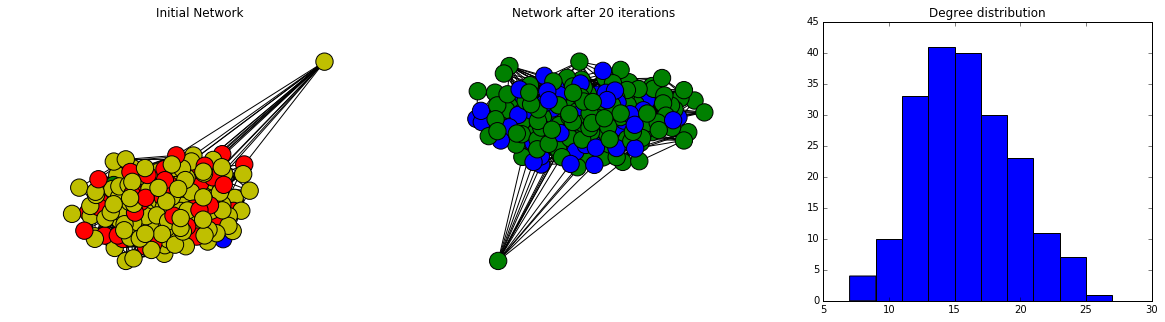

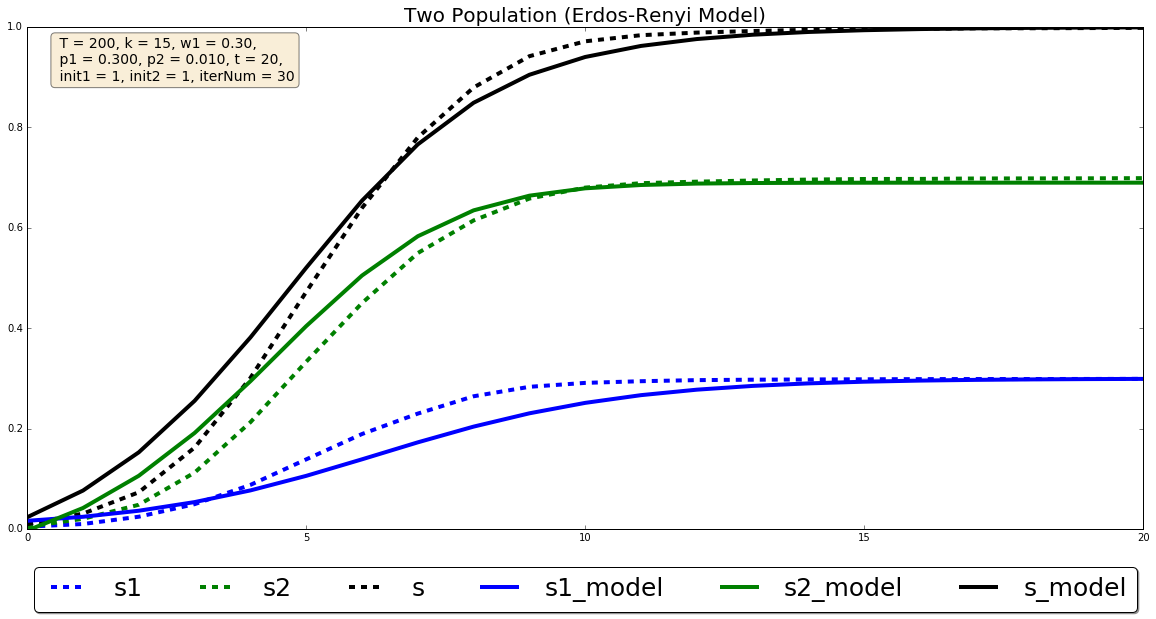

In [69]:
# Call the simulation

random.seed(0)

# Define Parameters
T = 200 
k = 15  
p1 = 0.3; p2 = 0.01
w1 = 0.3; w2 = 1 - w1
t = 20
init1 = 1
init2 = 1
iterNum = 30
T1 = int(T * w1); T2 = T - T1

simulate_TwoPopulation(T, k, p1, p2, w1, t,init1, init2, iterNum)

### Population with Hubs

Next, we define another two population model. In this model, there are two types of people : those with many friends and others with fewers friends. There could be many corresponding real life features, such as extroverts and introverts, or size of one's social network. For now, let's define it to be *SocialStanding*. We have parameters as follows : 

- $T,T_h,T_n$ : Total population, population group hub and non-hub
- $s_h,s_n$ : proportion of the total population in each group that has already heard the rumor
- $w_h,w_n$ : proportion of the total population that belongs to each group. That is, $T_h = w_h T$ and $T_n = w_n T$
- $p$ : probability that a spreader spreads information to an ignorant
- $\langle k_h \rangle,\langle k_n \rangle$ : average degree of the hubs and non-hubs, respectively

We follow similar derivations as the two population model before with slight modifications. Specifically, we no longer have a global $\langle k \rangle$ but group-specific average.

We have the following differential equations : 

$$\begin{align}
\frac{ds_h}{dt} &= p\frac{w_h\langle k_h \rangle}{C}\langle k_h \rangle s_h (w_h-s_h) + p \frac{w_h\langle k_h \rangle}{C} \langle k_n \rangle s_n (w_h-s_h)\\
\frac{ds_n}{dt} &= p\frac{w_n\langle k_n \rangle}{C} \langle k_n \rangle s_n (w_n-s_n) + p \frac{w_n\langle k_n \rangle}{C} \langle k_h \rangle s_h (w_n-s_n)\\
\text{where } C &= w_hk_h + w_nk_n
\end{align}$$


In [24]:
# Define the function that will spread the information in G
# for given spread probability p for t number of iterations
def spreadInfo_Hubs(G, T1set, T2set, spreaders1, spreaders2, p, t):
    n = G.number_of_nodes()
    NumSpreaders1 = [len(spreaders1)/n]
    NumSpreaders2 = [len(spreaders2)/n]
    iter = 0
    for i in range(t):
        iter = iter + 1
        newspreaders1 = spreaders1.copy()
        newspreaders2 = spreaders2.copy()
        for person in (spreaders1.union(spreaders2)) :
            neighbors = G.neighbors(person)
            for neighbor in neighbors:
                if (random.random() < p) and (neighbor not in newspreaders1) and  (neighbor not in newspreaders2) : 
                    if(neighbor in T1set) : 
                        newspreaders1.add(neighbor)
                        G.node[neighbor]['color'] = 'b'
                    else : 
                        newspreaders2.add(neighbor)
                        G.node[neighbor]['color'] = 'g'
        spreaders1 = newspreaders1.copy()
        spreaders2 = newspreaders2.copy()
        NumSpreaders1.append(len(spreaders1)/n)
        NumSpreaders2.append(len(spreaders2)/n)
        #if len(spreaders1) + len(spreaders2) == n:
        #    break
    return(G, spreaders1, spreaders2, NumSpreaders1, NumSpreaders2, iter)

# Create a configuration model for two populations
def create_configuration_model_two_population(deg, kh, inith, initn):
        Thset = set(); Tnset = set()
        spreadersh = set(); spreadersn = set();
        cm=nx.configuration_model(deg)

        # Assign the nodes to each group
        for i in range(T):
            if deg[i] == kh:
                Thset.add(i)
                cm.node[i]['color']='r'
            else : 
                Tnset.add(i)
                cm.node[i]['color']='y'

        # Just make one element from each set spreader
        initspreaderh = random.sample(Thset, inith)
        for i in initspreaderh:
            cm.node[i]['color'] = 'b'
            spreadersh.add(i)
            
        initspreadern = random.sample(Tnset, initn)
        for i in initspreadern:
            cm.node[i]['color'] = 'g'
            spreadersn.add(i)
        
        return [cm, Thset, Tnset, spreadersh, spreadersn]
    
# Create a Barabasi Albert model for two populations
def create_ba_model(T, m, init):
        spreaders = set();
        ba=nx.barabasi_albert_graph(T, m)
        for node in ba.nodes():
            ba.node[node]['color'] = 'w'

        # Make specified number of elements from each set spreader
        initspreader = random.sample(range(T), init)
        for i in initspreader:
            ba.node[i]['color'] = 'b'
            spreaders.add(i)
               
        return [ba, spreaders]


#Solve the result numerically
# import all the packages required 
import numpy as np
# Solve the differential equations  
from scipy.integrate import odeint

# Differential equation
def dfq_hubs(X,t):
    # lets assign some values to r, a, b and m
    sh=X[0];sn=X[1];
    ds1 = p*wh*kh/C*kh*sh*(wh-sh) + p*wh*kh/C*kn*sn*(wh-sh)
    ds2 = p*wn*kn/C*kn*sn*(wn-sn) + p*wn*kn/C*kh*sh*(wn-sn)
    
    return [ds1,ds2]

def dfq_hubs1(X,t):
    # lets assign some values to r, a, b and m
    sh=X[0];sn=X[1];
    ds1 = p*wh*kh*sh*(wh-sh) + p*wh*kn*sn*(wh-sh)
    ds2 = p*wn*kn*sn*(wn-sn) + p*wn*kh*sh*(wn-sn)
    
    return [ds1,ds2]

In [73]:
# Test the result on Configuration Model

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import random
import time
import math

def simulate_hubs_configuration(T, kh, kn, wh, p, t,inith, initn, iterNum):
    # Settle Parameters
    Th = int(T * wh); Tn = T - Th
    deg = [kh for i in range(0,Th)]
    deg = deg + [kn for i in range(0,Tn)]
    
    avgNumSpreadersh = np.array([0 for i in range(t+1)])
    avgNumSpreadersn = np.array([0 for i in range(t+1)])
    
    
    # Iterate for specificed amount
    for i in range(iterNum):
        random.shuffle(deg)

        # Initialize Variables
        
        [cm, Thset, Tnset, spreadersh, spreadersn] = create_configuration_model_two_population(deg, kh, inith, initn)
        
        if(i == 0):
            plt.figure(figsize=(20,5))
            plt.subplot(131)
            plt.title('Initial Network')
            nx.draw(cm,nx.fruchterman_reingold_layout(cm),with_labels=False,node_color=[cm.node[node]['color'] for node in cm])
        
        cm, spreadersh, spreadersn, NumSpreadersh, NumSpreadersn, tStop = spreadInfo_Hubs(cm, Thset, Tnset, spreadersh, spreadersn, p, t)
        if(i == 0):
            plt.subplot(132)
            plt.title('Network after '+ str(t)  + ' iterations')
            nx.draw(cm,nx.fruchterman_reingold_layout(cm),with_labels=False,node_color=[cm.node[node]['color'] for node in cm])
            plt.subplot(133)
            plt.title('Degree distribution')
            plt.hist(list(cm.degree().values()))
            
        avgNumSpreadersh = avgNumSpreadersh + np.array(NumSpreadersh)
        avgNumSpreadersn = avgNumSpreadersn + np.array(NumSpreadersn)
    
    
    # Times at which the solution is to be computed.
    tSpan = np.arange(0, t+1, 1)
    Xinit=np.array([inith/Th,initn/Tn])
    Xsolu = odeint(dfq_hubs, Xinit, tSpan)
    
    avgNumSpreadersh = avgNumSpreadersh / iterNum
    avgNumSpreadersn = avgNumSpreadersn / iterNum
    
    avgNumSpreaders = avgNumSpreadersh + avgNumSpreadersn
    
    plt.figure(figsize=(20,10))
    ax = plt.subplot(111)
    sh, = plt.plot(avgNumSpreadersh, 'b--',linewidth=4)
    sn, = plt.plot(avgNumSpreadersn, 'g--',linewidth=4)
    s, = plt.plot(avgNumSpreaders, 'k--',linewidth=4)
    sh_model, = plt.plot(Xsolu[:,0], 'b', linewidth =4)
    sn_model, = plt.plot(Xsolu[:,1]-0.01, 'g', linewidth =4)
    s_model, = plt.plot(Xsolu[:,0] + Xsolu[:,1], 'k', linewidth =4)
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
    ax.legend([sh, sn, s, sh_model, sn_model, s_model], ['sh', 'sn', 's', 'sh_model', 'sn_model', 's_model'],
              loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=6, fontsize = 25)
    
    text = ' T = %d, kh = %d, kn = %d,\n wh = %.2f, p = %.3f, t = %d,\n inith = %d, initn = %d, iterNum = %d' %(T,kh,kn,wh,p,t,inith,initn,iterNum) 
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.5, .98, text,fontsize=14, verticalalignment='top', bbox=props)
    plt.title('Population with hubs (configuration model)',fontsize = 20)

    plt.xlim(0,t)
    plt.ylim(0,1)


In [76]:
# Test the result on Barabasi-Albert Model

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import random
import time
import math

def simulate_hubs_ba(T, m, p, t, kh, kn, wh, init,iterNum):
    Th = int(T * wh); Tn = T - Th
    avgNumSpreaders = np.array([0 for i in range(t+1)])
    avgDegrees = np.array([0 for i in range(T)])
    
    for i in range(iterNum):
        [ba, ba_spreaders] = create_ba_model(T, m, init)
        
        if(i == 0):
            plt.figure(figsize=(20,5))
            plt.subplot(131)
            plt.title('Initial Network')
            nx.draw(ba,nx.circular_layout(ba),with_labels=False,node_color=[ba.node[node]['color'] for node in ba])
        
        ba, ba_spreaders, ba_NumSpreaders, ba_tStop = spreadInfo(ba, ba_spreaders, p, t)
        if(i == 0):
            plt.subplot(132)
            plt.title('Network after '+ str(t)  + ' iterations')
            nx.draw(ba,nx.circular_layout(ba),with_labels=False,node_color=[ba.node[node]['color'] for node in ba])

        avgNumSpreaders = avgNumSpreaders + np.array(ba_NumSpreaders)
        avgDegrees = avgDegrees + np.array(list(ba.degree().values()))
    
    avgNumSpreaders = avgNumSpreaders / iterNum
    avgDegrees = avgDegrees / iterNum
    
    plt.subplot(133)
    plt.title('Degree distribution (Average)')
    plt.hist(avgDegrees)
    
    # Compute theoretical Model
    
    tSpan = np.arange(0, t+1, 1)
    Xinit=np.array([1/Th,0/Tn]) # initial condition
    Xsolu1 = odeint(dfq_hubs, Xinit, tSpan)
    
    Xinit2=np.array([0/Th,1/Tn]) # initial condition
    Xsolu2 = odeint(dfq_hubs, Xinit2, tSpan)
    
    plt.figure(figsize=(20,10))
    ax = plt.subplot(111)
    s, = plt.plot(avgNumSpreaders, 'b--',linewidth=4)
    s_model1, = plt.plot(Xsolu1[:,0] + Xsolu1[:,1], 'r', linewidth =4)
    s_model2, = plt.plot(Xsolu2[:,0] + Xsolu2[:,1], 'g', linewidth =4)
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
    ax.legend([s, s_model1, s_model2], ['s', 's_model (initial = hub)', 's_model (initial = non-hub)'],
              loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=3, fontsize = 25)

    text = ' T = %d, m = %d, p = %.3f,t = %d,\n kh = %d, kn = %d, wh = %.3f, \n init = %d, iterNum = %d' %(T, m, p, t, kh, kn, wh, init, iterNum) 
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.5, .98, text,fontsize=14, verticalalignment='top', bbox=props)
    plt.title('(B-A model)',fontsize = 20)

    plt.xlim(0,t)
    plt.ylim(0,1)


#### Simulation on configuration Model

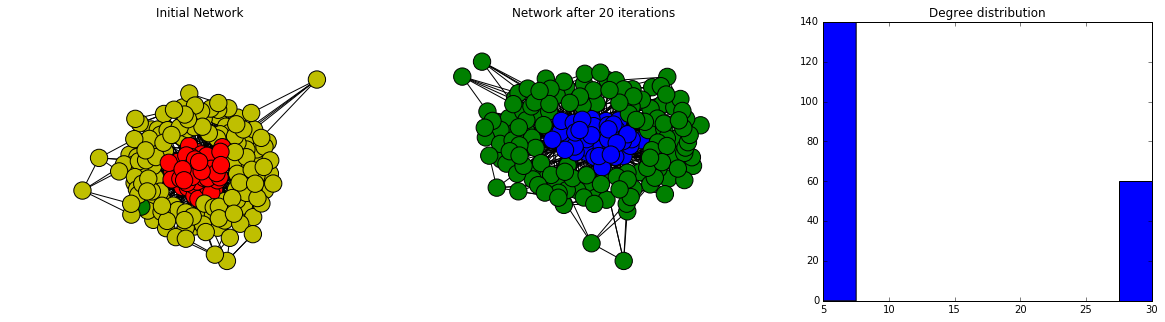

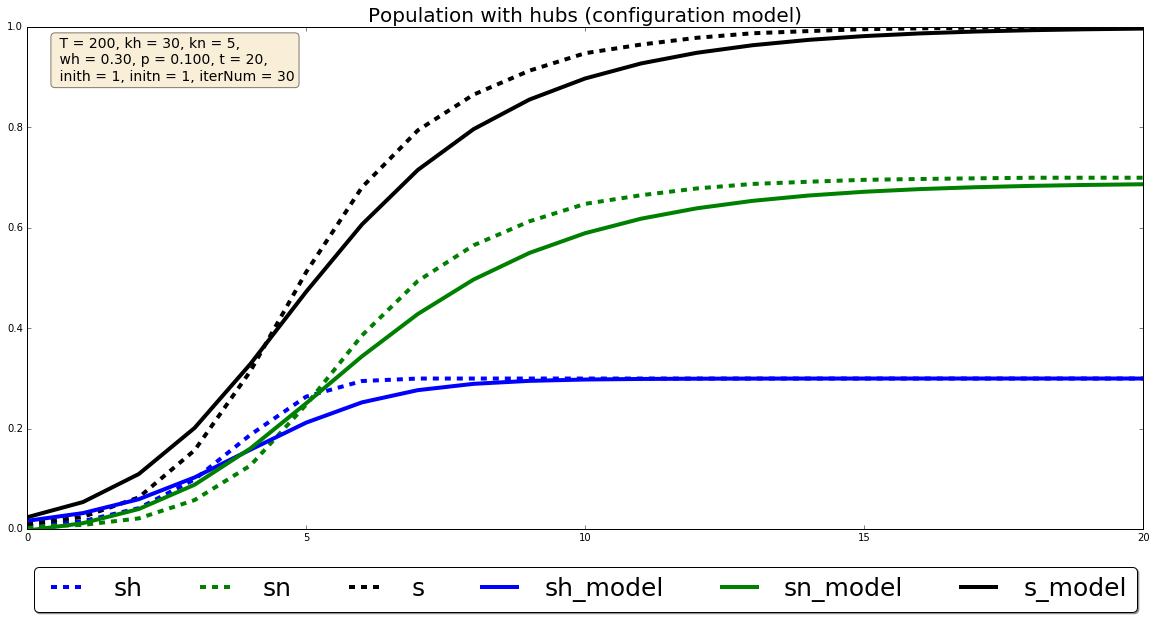

In [75]:
# Call the simulation

random.seed(0)

# Define Parameters
T = 200
kh = 30; kn = 5
wh = 0.3; wn = 1 - wh
p = 0.1
t = 20
inith = 1 # Inital number of spreaders among hubs
initn = 1 # initial number of spreaders among nonhubs
iterNum = 30
C = wh*kh + wn*kn

simulate_hubs_configuration(T, kh, kn, wh, p, t,inith, initn, iterNum)

#### Simulation on BA Model

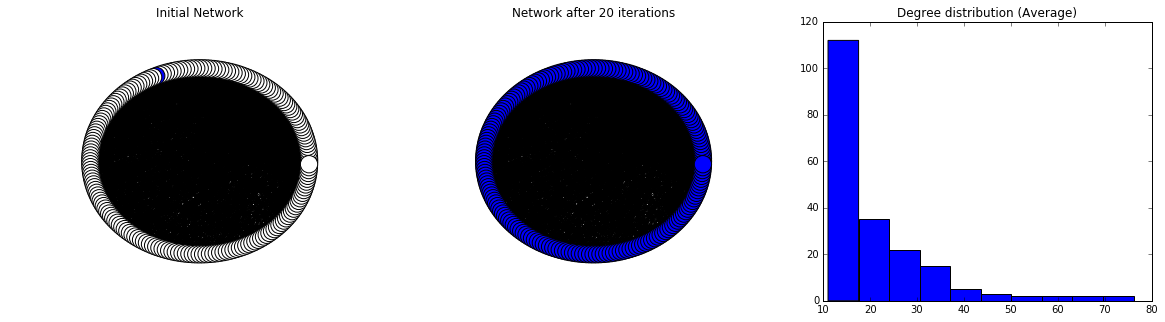

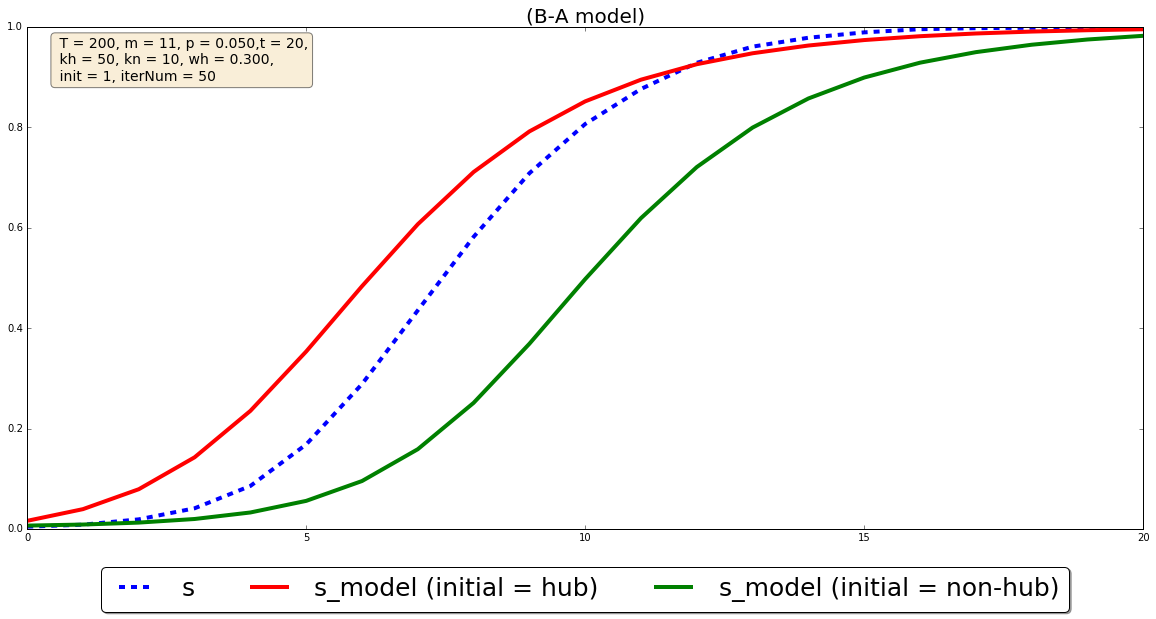

In [77]:
# Call the simulation

random.seed(0)

# Define Parameters
T = 200
kh = 50; kn = 10
wh = 0.3; wn = 1 - wh
m = int((kh*wh + kn*wn) / 2)
p = 0.05
t = 20
init = 1 # Inital number of spreaders 
iterNum = 50
C = wh*kh + wn*kn

simulate_hubs_ba(T, m, p, t, kh, kn, wh, init,iterNum)

### Final Model + Antirumor

Next, we define the final model. We combine previous two models : there are two types of people : those with many friends and others with fewers friends. We further define that each group of people have different probability of spreading rumor. Further, we introduce a parameter for the significance of rumor, from a scale of 0 to 1. Lastly, we assume that at t_0, some source (e.g. legislators) spread antirumor that instantly affects everyone, reducing there probability of spreading rumor and making someone not believe in rumor anymore.
We have parameters as follows : 

- $T,T_h,T_n$ : total population, population group hub and non-hub
- $s_h,s_n$ : proportion of the total population in each group that has already heard the rumor
- $w_h,w_n$ : proportion of the total population that belongs to each group. That is, $T_h = w_h T$ and $T_n = w_n T$
- $p_h,p_n$ : probability that a spreader spreads information to an ignorant, for each group
- $\langle k_h \rangle,\langle k_n \rangle$ : average degree of the hubs and non-hubs, respectively
- $p_a$ : how convincing the antirumor is. Probability of spreading rumor to an ignorant will be reduced to $p(1-p_a)$ after policy is announced
- $r$ : proportion of people who has heard the rumor but decides not to believe it anymore due to antirumor at every timestamp
- $t_0$ : time when antirumour is spread
- $I$ : intensity of information (value between 0 and 1). Then probability of spreading rumor is $p*s$. 1 is a very significant information. If information is not important at all (0), the information spreading probability will be reduced to 0.

We follow similar derivations as the two population model before with slight modifications. Specifically, we no longer have a global $\langle k \rangle$ but group-specific average. We also take into account $s,p_a$ and $r$

We have the following differential equations : 

$$\begin{align}
\frac{ds_h}{dt} &= Ip_h\frac{w_h\langle k_h \rangle}{C}\langle k_h \rangle s_h (w_h-s_h) + Ip_n \frac{w_h\langle k_h \rangle}{C} \langle k_n \rangle s_n (w_h-s_h)\\
\frac{ds_n}{dt} &= Ip_n\frac{w_n\langle k_n \rangle}{C} \langle k_n \rangle s_n (w_n-s_n) + Ip_h \frac{w_n\langle k_n \rangle}{C} \langle k_h \rangle s_h (w_n-s_n)\\
\text{where } C &= w_hk_h + w_nk_n
\end{align}$$

Assume antirumor is spread at timestamp $t_0$. Then our changed equation is
$$\begin{align}
\frac{ds_h}{dt} &= Ip_h(1-p_a)\frac{w_h\langle k_h \rangle}{C}\langle k_h \rangle s_h (w_h-s_h) + Ip_n(1-p_a) \frac{w_h\langle k_h \rangle}{C} \langle k_n \rangle s_n (w_h-s_h) - rs_h\\
\frac{ds_n}{dt} &= Ip_n(1-p_a)\frac{w_n\langle k_n \rangle}{C} \langle k_n \rangle s_n (w_n-s_n) + Ip_h(1-p_a) \frac{w_n\langle k_n \rangle}{C} \langle k_h \rangle s_h (w_n-s_n)- rs_n\\
\text{where } C &= w_hk_h + w_nk_n
\end{align}$$

Export Image?



In [94]:
# Define the function that will spread the information in G
# for given spread probability p1, p2 for t number of iterations
def spreadInfo_Final(G, Thset, Tnset, spreadersh, spreadersn, I, ph, pn, pa, t, t0,r):
    n = G.number_of_nodes()
    NumSpreadersh = [len(spreadersh)/n]
    NumSpreadersn = [len(spreadersn)/n]
    iter = 0
    ph = I * ph
    pn = I * pn
    
    for i in range(0,t):
        # Reduce the probability once antirumor is spread
        if(i == t0):
            ph = ph * (1-pa)
            pn = pn * (1-pa)
        
        iter = iter + 1
        newspreadersh = spreadersh.copy()
        newspreadersn = spreadersn.copy()
        for person in spreadersh :
            neighbors = G.neighbors(person)
            for neighbor in neighbors:
                if (random.random() < ph) and (neighbor not in newspreadersh) and  (neighbor not in newspreadersn) : 
                    if(neighbor in Thset) : 
                        newspreadersh.add(neighbor)
                        G.node[neighbor]['color'] = 'b'
                    else : 
                        newspreadersn.add(neighbor)
                        G.node[neighbor]['color'] = 'g'
        for person in spreadersn :
            neighbors = G.neighbors(person)
            for neighbor in neighbors:
                if (random.random() < pn) and (neighbor not in newspreadersh) and  (neighbor not in newspreadersn) : 
                    if(neighbor in Thset) : 
                        newspreadersh.add(neighbor)
                        G.node[neighbor]['color'] = 'b'
                    else : 
                        newspreadersn.add(neighbor)
                        G.node[neighbor]['color'] = 'g'
        
        # Recovering probability
        if(i >= t0):
            for person in spreadersh:
                if(random.random() < r):
                    newspreadersh.remove(person)
                    G.node[person]['color'] = 'r'
            for person in spreadersn:
                if(random.random() < r):
                    newspreadersn.remove(person)
                    G.node[person]['color'] = 'y'
            
        spreadersh = newspreadersh.copy()
        spreadersn = newspreadersn.copy()
        NumSpreadersh.append(len(spreadersh)/n)
        NumSpreadersn.append(len(spreadersn)/n)

    return [G, spreadersh, spreadersn, NumSpreadersh, NumSpreadersn, iter]


# Creates a two population as desired
def create_final(G, Th, inith, initn):
    Thset = set(); Tnset = set()
    spreadersh = set(); spreadersn = set();
    index = [i for i in range(T)]
    random.shuffle(index)
    indexer = 0

    # Assign the nodes to each group
    for i in index:
        indexer = indexer + 1
        if(indexer <= Th):
            Thset.add(i)
            G.node[i]['color']='r'
        else:
            Tnset.add(i)
            G.node[i]['color']='y'

    # Just make specified number of elements from each set spreader
    initspreaderh = random.sample(Thset, inith)
    for i in initspreaderh:
        G.node[i]['color'] = 'b'
        spreadersh.add(i)

    initspreadern = random.sample(Tnset, initn)
    for i in initspreadern:
        G.node[i]['color'] = 'g'
        spreadersn.add(i)

    return [G, Thset, Tnset, spreadersh, spreadersn]

# Create a erdos Renyi model for two populations
def create_er_final(T,k,wh,inith, initn):
    p_edge = float(k)/T
    er=nx.erdos_renyi_graph(T,p_edge)
    Th = int(T * wh)
    [G, Thset, Tnset, spreadersh, spreadersn] = create_final(er, Th, inith, initn)
    return [G, Thset, Tnset, spreadersh, spreadersn]

# Creates Barabasi Albert Model
def create_ba_final(T,m,wh,inith, initn):
    ba=nx.barabasi_albert_graph(T, m)
    Th = int(T * wh)
    [G, Thset, Tnset, spreadersh, spreadersn] = create_final(ba, Th, inith, initn)
    return [G, Thset, Tnset, spreadersh, spreadersn]

# Creates Watts Strogatz Model
def create_ws_final(T, k, wh, p_rewire, inith, initn):
    ws=nx.watts_strogatz_graph(T,k,p_rewire) 
    Th = int(T * wh)
    [G, Thset, Tnset, spreadersh, spreadersn] = create_final(ws, Th, inith, initn)
    return [G, Thset, Tnset, spreadersh, spreadersn]
    
    
    # Create a configuration model for two populations
def create_configuration_final(deg, kh, inith, initn):
    Thset = set(); Tnset = set()
    spreadersh = set(); spreadersn = set();
    cm=nx.configuration_model(deg)

    # Assign the nodes to each group
    for i in range(T):
        if deg[i] == kh:
            Thset.add(i)
            cm.node[i]['color']='r'
        else : 
            Tnset.add(i)
            cm.node[i]['color']='y'

    # Just make one element from each set spreader
    initspreaderh = random.sample(Thset, inith)
    for i in initspreaderh:
        cm.node[i]['color'] = 'b'
        spreadersh.add(i)

    initspreadern = random.sample(Tnset, initn)
    for i in initspreadern:
        cm.node[i]['color'] = 'g'
        spreadersn.add(i)

    return [cm, Thset, Tnset, spreadersh, spreadersn]

    
#Solve the result numerically

# import all the packages required 
import numpy as np
# Solve the differential equations  
from scipy.integrate import odeint

# Differential equation
def dfq_final(X,t):
    # lets assign some values to r, a, b and m
    sh=X[0];sn=X[1];
    C = wh*kh + wn*kn
    dsh = I*ph*wh*kh/C*kh*sh*(wh-sh) + I*pn*wh*kh/C*kn*sn*(wh-sh)
    dsn = I*pn*wn*kn/C*kn*sn*(wn-sn) + I*ph*wn*kn/C*kh*sh*(wn-sn)
    
    return [dsh,dsn]

def dfq_final_antirumor(X,t):
    sh=X[0];sn=X[1];
    C = wh*kh + wn*kn
    dsh = I*ph*(1-pa)*wh*kh/C*kh*sh*(wh-sh) + I*pn*(1-pa)*wh*kh/C*kn*sn*(wh-sh)-r*sh
    dsn = I*pn*(1-pa)*wn*kn/C*kn*sn*(wn-sn) + I*ph*(1-pa)*wn*kn/C*kh*sh*(wn-sn)-r*sn
    
    return [dsh,dsn]
    

In [98]:
# Test the result

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import random
import time
import math


def simulate_final(T, kh, kn, wh, ph, pn, p_rewire, I, pa, r, t, t0, inith, initn, iterNum, options):    
    # Parameters automatically computed
    Th = int(T * wh); Tn = T - Th
    wn = 1 - wh
    k = int((kh*wh + kn*wn))
    m = int((kh*wh + kn*wn) / 2)
    deg = [kh for i in range(0,Th)]
    deg = deg + [kn for i in range(0,Tn)]
    C = wh*kh + wn*kn
    Th = int(T * wh); Tn = T - Th
    avgNumSpreadersh = np.array([0 for i in range(t+1)])
    avgNumSpreadersn = np.array([0 for i in range(t+1)])
    avgDegrees = np.array([0 for i in range(T)])
    
    for opt in options:
        if (opt == 0):
            [G, Thset, Tnset, spreadersh, spreadersn] = create_er_final(T,k,wh, inith, initn)
        elif (opt == 1):
            [G, Thset, Tnset, spreadersh, spreadersn] = create_configuration_final(deg, kh, inith, initn)
        elif(opt == 2):
            [G, Thset, Tnset, spreadersh, spreadersn] = create_ws_final(T, k, wh, p_rewire, inith, initn)
        elif(opt == 3):
            [G, Thset, Tnset, spreadersh, spreadersn] = create_ba_final(T,m,wh, inith, initn)

        for i in range(iterNum):
        
            if(i == 0):
                plt.figure(figsize=(20,5))
                plt.subplot(131)
                plt.title('Initial Network')
                nx.draw(G,nx.fruchterman_reingold_layout(G),with_labels=False,node_color=[G.node[node]['color'] for node in G])

            G, spreadersh, spreadersn, NumSpreadersh, NumSpreadersn, tStop = spreadInfo_Final(G, Thset, Tnset, spreadersh, spreadersn, I, ph, pn, pa, t, t0,r)    

            if(i == 0):
                plt.subplot(132)
                plt.title('Network after '+ str(t)  + ' iterations')
                nx.draw(G,nx.fruchterman_reingold_layout(G),with_labels=False,node_color=[G.node[node]['color'] for node in G])

            avgNumSpreadersh = avgNumSpreadersh + np.array(NumSpreadersh)
            avgNumSpreadersn = avgNumSpreadersn + np.array(NumSpreadersn)
            avgDegrees = avgDegrees + np.array(list(G.degree().values()))
    
        avgNumSpreadersh = avgNumSpreadersh / iterNum
        avgNumSpreadersn = avgNumSpreadersn / iterNum
        avgDegrees = avgDegrees / iterNum
    
        plt.subplot(133)
        plt.title('Degree distribution (Average)')
        plt.hist(avgDegrees)
    
        # Compute theoretical Model
    
        tSpan = np.arange(0, t0+1, 1)
        Xinit = np.array([inith/Th,initn/Tn]) # initial condition
        Xsolu = odeint(dfq_final, Xinit, tSpan)
        
        tSpan_anti = np.arange(t0,t+1, 1)
        inith_anti = Xsolu[len(Xsolu[:,0])-1,0]
        initn_anti = Xsolu[len(Xsolu[:,1])-1,1]
        Xinit_anti = np.array([inith_anti,initn_anti])
        Xsolu_anti = odeint(dfq_final_antirumor, Xinit_anti, tSpan_anti)
    
        plt.figure(figsize=(20,10))
        ax = plt.subplot(111)
        sh, = plt.plot(avgNumSpreadersh, 'b--',linewidth=4)
        sn, = plt.plot(avgNumSpreadersn, 'g--',linewidth=4)
        s, = plt.plot(avgNumSpreadersh+avgNumSpreadersn, 'k--',linewidth=4)
    
        # Combine two results
        Xsolutionh = np.concatenate([Xsolu[:,0],Xsolu_anti[1:,0]])
        Xsolutionn = np.concatenate([Xsolu[:,1],Xsolu_anti[1:,1]])
    
        dfq_modelh, = plt.plot(Xsolutionh, 'b', linewidth =4)
        dfq_modeln, = plt.plot(Xsolutionn, 'g', linewidth =4)
        dfq_model, = plt.plot(Xsolutionh + Xsolutionn, 'k', linewidth =4)
    
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
        ax.legend([s, sh, sn, dfq_modelh, dfq_modeln, dfq_model], ['s', 'sh', 'sn', 'dfq_modelh', 'dfq_modeln', 'dfq_model'],
                  loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=6, fontsize = 25)

        
        # Change title accordingly
        if (opt == 0):
            text = ' T = %d, kh = %d, kn = %d, wh = %.3f, \n ph = %.3f, pn = %.3f, I = %.3f, pa = %.3f, \n r = %.3f, t = %d, t0 = %d, \n inith = %d, initn =%d, iterNum = %d\n k=%.3f' %(T, kh, kn, wh, ph, pn, I, pa, r, t, t0, inith, initn, iterNum,k) 
            plt.title('(E-R Model)',fontsize = 20)
        elif (opt == 1):
            text = ' T = %d, kh = %d, kn = %d, wh = %.3f, \n ph = %.3f, pn = %.3f, I = %.3f, pa = %.3f, \n r = %.3f, t = %d, t0 = %d, \n inith = %d, initn =%d, iterNum = %d' %(T, kh, kn, wh, ph, pn, I, pa, r, t, t0, inith, initn, iterNum) 
            plt.title('(Configuration Model)',fontsize = 20)
        elif(opt == 2):
            text = ' T = %d, kh = %d, kn = %d, wh = %.3f, \n ph = %.3f, pn = %.3f, I = %.3f, pa = %.3f, \n r = %.3f, t = %d, t0 = %d, \n inith = %d, initn =%d, iterNum = %d\n k=%.3f, p_rewire=%.3f' %(T, kh, kn, wh, ph, pn, I, pa, r, t, t0, inith, initn, iterNum,k,p_rewire) 
            plt.title('(W-S Model)',fontsize = 20)
        elif(opt == 3):
            text = ' T = %d, kh = %d, kn = %d, wh = %.3f, \n ph = %.3f, pn = %.3f, I = %.3f, pa = %.3f, \n r = %.3f, t = %d, t0 = %d, \n inith = %d, initn =%d, iterNum = %d\n m=%d' %(T, kh, kn, wh, ph, pn, I, pa, r, t, t0, inith, initn, iterNum,m) 
            plt.title('(B-A model)',fontsize = 20)

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        plt.text(0.5, .98, text,fontsize=14, verticalalignment='top', bbox=props)
        plt.xlim(0,t)
        plt.ylim(0,1)

10
10
p_edge
1.0


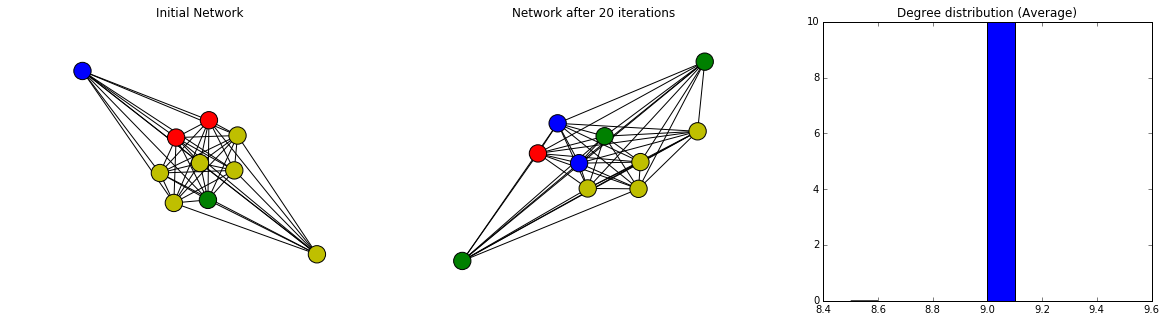

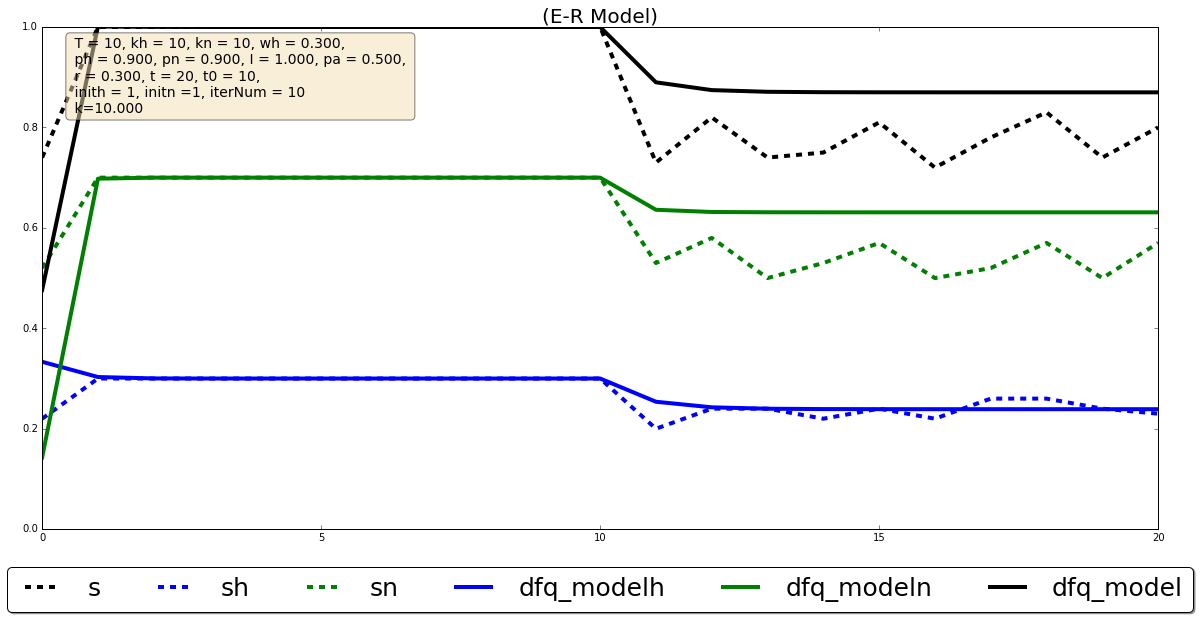

In [99]:
# All the Parameters
T = 10
kh = 10; kn = 10
wh = 0.3; wn = 1 - wh
ph = 0.9; pn = 0.9
p_rewire = 0.3 # for W-S Model
I = 1
pa = 0.5
r = 0.3
t = 20
t0 = 10
inith = 1 # Inital number of spreaders 
initn = 1
iterNum = 10
options = [0,1,2,3] # 0 = ER, 1 = Configuration, 2 = Watts-Strogatz, 3 = Barabasi-Albert
options = [0]

simulate_final(T, kh, kn, wh, ph, pn, p_rewire, I, pa, r, t, t0, inith, initn, iterNum, options)    


In [15]:
a[1:]

[2, 3]